<a href="https://colab.research.google.com/github/Kinds-of-Intelligence-CFI/measurement-layout-tutorial/blob/main/tutorial-notebooks/3_A_BayesianInferenceWithPyMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Introduction to Bayesian Inference with PyMC

The aim of this notebook is to give participants an introduction to Bayesian Inference within the PyMC library. Participants that are familiar with PyMC may want to skip ahead to the next notebook where the Measurement Layouts framework is introduced properly.

At the core of the Measurement Layouts framework (and all Bayesian models) is Bayes rule:
$$ P(\theta \mid x) = \frac{P(\theta) \cdot P(x \mid \theta)}{P(x)}$$

This rule gives an approach for updating our beliefs ($\theta$) based on observed evidence ($x$).

We will dive into a more detailed overview of Bayesian models later but first we should set up the colab environment to have the correct libraries.


In [ ]:
import pymc as pm
import numpy as np
import arviz as az
import random as rm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.2


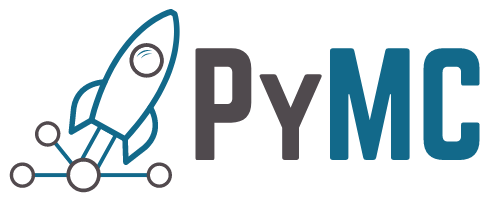



[PyMC](https://colab.research.google.com/drive/1wgUL7E7B9IAJWor8FchAOo4Fy-BTZCEc#scrollTo=9jBNnTe2Nqt6) is a probabilistic programming Python framework. This makes it great for Bayesian modelling.






## Cats and Dogs Dataset Example
Let's take a look at a simple example of something we can achieve with PyMC.
Imagine we have a large dataset consisting of thousands of pictures of cats and dogs. We created the dataset by taking pictures of the two animals ourselves. In our haste to create a good dataset we forgot to label the images. Suppose now that we want to estimate the proportion of images that are cats and the proportion that are dogs. This is a simple task that we could do without PyMC, but we can use it to illustrate many of PyMC's properties.

We need to formulate the problem probabilistically.
Since we know that there are only two options available in  the dataset, and that the images in the dataset are independent when sampled, we can model the sampling process as a Bernoulli distribution.

$$ x \sim Ber(\theta) $$

That is, $P(x = ``cat'') = \theta$, $P(x = ``dog'') = 1-\theta$.

Repeatedly sampling from a Bernoulli distribution $n$ times is equivalent to the Binomial distribution:

$$ x \sim Bin(n, \theta)  $$


The problem now is to find the most accurate value of $\theta$.

Our initial belief about $\theta$ is completely uninformative (we were too busy taking pictures to remember a rough estimate at all). But we do know that it has to be between 0 and 1.

We can therefore model the parameter $\theta$ as originating from a distribution itself. We will model this distribution as:
$$\theta \sim Beta(1,1)$$
This is a flat uniform distribution, which can be altered to allocate more probability mass to different areas as we get more evidence.

We take a small random sample of 105 photos and we label them. 30 are dogs and 75 are cats. Let's call 'cats' the positive class.

We can express all of this in PyMC. Let's take a look.

In [ ]:
dogsObserved = 30
catsObserved = 75

m = pm.Model()

with  m:
  theta = pm.Beta("theta", 1,1)
  observedImage = pm.Binomial("Observations", p=theta, n=dogsObserved+catsObserved, observed=catsObserved)




We first have the observed data. Then we create a model, and inside it (the "with m" part) we define its structure: one single parameter theta as well as how the observed image depends on theta as the outcome of a binomial distribution.



The model has just been created, but it hasn't estimated any parameter. We have defined its structure, but haven't performed any Bayesian inference yet. For that we can use PyMC's sampling method to use backwards inference to estimate parameter $\theta$:

(note this can take a few seconds)

In [ ]:
with m:
  inferenceData = pm.sample(10000)

As a Monte Carlo method, the parameter in pm.sample indicates how many times we sample in each of the two 'chains' (by default there are two Markov chains used by the MCMC NUTs algorithm in PyMC is using). The details of this aren't needed right now, but we may dive into more detail later on.

This inferenceData variable contains the inferred parameters. It gives us a lot of data and statistics from the inference process. Right now, what we want to look at is the posterior distribution for $\theta$:

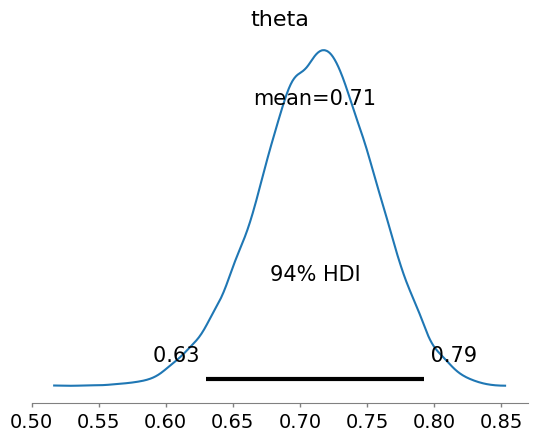

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

az.plot_posterior(inferenceData, ax=ax);

plt.show()

This represents an allocation of probability mass over $[0,1]$ for our distribution of $\theta$ based on evidence observed $x$. The posterior distribution is in blue. The mean of this distribution is 0.71, which is close to 75/(30+75)= 0.714, as expected.

The black bar indicates the 94% High Density Interval.


To better understand what is going on here, we need to realise we're inferring *a distribution for* $\theta$, not just a single value. What's the distribution of $\theta$? We chose the beta distribution for $\theta$ because the Beta distribution is the conjugate distribution to the binomial distribution (see, e.g., https://en.wikipedia.org/wiki/Conjugate_prior). In this case we can do part of the inversion process analytically, and see that when repeating a sample from a beta distribution many times (let's say 100000) where the parameters $\alpha$ and $\beta$ of the beta distribution are the absolute frequencies plus one (30+1 and 75+1 in this case) we get this plot in red:

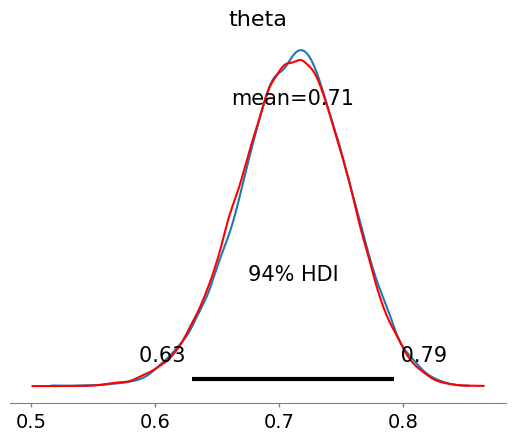

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

az.plot_posterior(inferenceData, ax=ax);

a = np.random.beta(76,31, 100000)
az.plot_dist(a, ax=ax, color="red")
plt.show()

An approximation of the exact distribution is in red which matches our posterior distribution almost perfectly. In many cases we won't be able to do this check using the conjugate priors, but in this simple case it allows us to see how the backwards inference leads to a distribution for $\theta$.

This example was rather simple, but demonstrates the inference algorithm in PyMC and the simplicity of defining the structure of the model.


## U-Turn Sampler and Differentiability

PyMC's inference engine is the No U-Turn Sampler (see [here](https://arxiv.org/abs/1111.4246)). This No U-Turn Sampler (NUTS), an extension to Hamiltonian (Markov Chain) Monte Carlo methods, eliminates the need to set particular hyper-parameters.

With the NUTS sampler we use 2 sampling chains. In the example above, the first chain is tuned for $1000$ samples that are discarded in order to optimise the step-size within NUTS, and then draw $1000$ samples to estimate the posterior.

Note that for PyMC to work, all functions connecting the elements through which inference goes must be **differentiable**. We must avoid max and min functions, or conditions (if-then-else) that depend on some given values of the parameters being estimated. In many cases, there are continuous equivalents to these functions, using sum, products, and other algebraic operations.

Now that you have the basics of what PyMC can do, and how to build basic models, and sample them, you are ready to move on and see how we implement the measurement layouts framework in PyMC.